# Cluster Interaction Analysis

**Author**: Alma Andersson<br>
**Description**:<br>
<br>
Workflow to assess patterns of interaction between different clusters.
For every spot within each cluster we register the identity of the 4 nearest neighbors (NN) (with a distance less than a threshold to said spot). By doing so we can then compute - for each cluster - the fraction of NNs that belong to each respective cluster. By permuting the cluster labels, a null distribution can be generated to put the observed values into context.
<hr>

In [102]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import packages and set global variables

`K` is the number of NNs to use and `EPS_FACTOR` is used to compute the distance threshold, the larger the value the large the allowed distance will be. For 2K arrays,`1.3` has provided good results.

In [6]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import glob
import os.path as osp
from typing import *

In [7]:
K = 4
EPS_FACTOR = 1.3 

### Data-related variables

In [8]:
# directory to load data from
DATA_DIR = "../rsc/cluster/"
# directory to save results to
RES_DIR = "../res/cluster/nbrs/"
# make results directory if not already exists
if not osp.exist(RES_DIR):
    from os import mkdir
    mkdir(RES_DIR)
    
# get paths for data files
pths = glob.glob(osp.join(DATA_DIR,
                          "*tsv"))

## Load data

In [16]:
# load data from list of paths
data = list()
for pth in pths:
    _tmp = pd.read_csv(pth,
                       sep = "\t",
                       header = 0,
                       index_col = 0,
                      )
    data.append(_tmp)

In [17]:
def generate_stats(data : List[pd.DataFrame],
                   cluster_label : str = "cluster",
                   )->Dict[str,pd.DataFrame]:
    
    """Generate NN stats
    
    Parameters:
    ----------
    
    data : List[pd.DataFrame]
        list of pandas data frame holding cluster
        data. Assumes cluster labels are same across
        whole data set.
    cluster_label : str (cluster)
        name of column holding cluster
        information
    
    Returns:
    -------
    Dictionary with stats for each cluster
    
    """

    all_sample_stats = dict()
    all_labels = list()

    for _tmp in data:

        _drop = np.isnan(_tmp[cluster_label].values)
        _tmp = _tmp.iloc[~_drop,:]

        _crd = _tmp[["new_x","new_y"]].values
        _crd /= _crd.max()
        _kd = KDTree(_crd)

        ds,idxs = _kd.query(_crd, k =  2)
        upper_bound = ds[:,1::].mean() * EPS_FACTOR  * 0.9

        ds,idxs = _kd.query(_crd,
                            k = K +1,
                            distance_upper_bound = upper_bound)
        ds = ds[:,1::]
        idxs = idxs[:,1::]

        uni_labels = np.unique(_tmp[cluster_label].values)
        np.sort(uni_labels)

        all_labels += uni_labels.tolist()

        n_labels = uni_labels.shape[0]

        tmp_labels = np.append(_tmp[cluster_label].values,"none")

        for label in uni_labels:
            if label not in all_sample_stats.keys():
                all_sample_stats[label] = list()

            pos = np.where(_tmp[cluster_label].values == label)[0]

            nn_stats = np.zeros((pos.shape[0],
                                 n_labels + 1,
                                ))

            nn_stats = pd.DataFrame(nn_stats,
                                    columns = pd.Index(np.append(uni_labels,"none")\
                                                       .astype(str)),
                               )

            for k,p in enumerate(pos):
                nbr_labels = tmp_labels[idxs[p,:]]
                val,cnt = np.unique(nbr_labels,return_counts = True)
                nn_stats.loc[k,val.astype(str)] = cnt

            all_sample_stats[label].append(nn_stats.iloc[:,nn_stats.columns != "none"])

    for k,v in all_sample_stats.items():
        all_sample_stats[k] = pd.concat(v)
        
    return all_sample_stats

## Analysis

Compute NN stats for respective cluster across the whole data set and add reference from null distribution if specified.

In [80]:
# set to true to add null distribution
# can take some time
include_reference = True
# name of column holding cluster information
cluster_label = "cluster"

# get stats for complete data set
all_sample_stats = generate_stats(data,
                                 cluster_label = cluster_label,
                                 )

# generate and compute null distribution
if include_reference:
    n_iter = 100
    from copy import deepcopy
    perm_stats = dict()

    for k,d in all_sample_stats.items():
        perm_stats[k] = np.zeros((n_iter,d.shape[1]))


    for ii in range(n_iter):
        print("\rIteration {:2.0f}/{}".format(ii+1,n_iter),end="")
        tmp_data = list()
        for d in data:
            perm_cidx = np.permutation(d.shape[0])
            _tmp = deepcopy(d)
            _tmp[cluster_label] = _tmp[cluster_label].values[perm_cidx]
            tmp_data.append(_tmp)
            
        tmp_stats = generate_stats(tmp_data,
                                  cluster_label = cluster_label,
                                  )
        for k,v in tmp_stats.items():
            perm_stats[k][ii,:] = v.values.sum(axis=0)
            perm_stats[k][ii,:] /= perm_stats[k][ii,:].sum()

    for k,v in perm_stats.items():
        perm_stats[k] = dict(mean = perm_stats[k].mean(axis = 0),
                             std = perm_stats[k].std(axis= 0)
                            )

## Visualize results

visualize the interaction analysis using bar-graphs, one graph per cluster. Bars represent the fraction of NNs that belong to each cluster, the "self" cluster is indicated with gray. If reference is specified to be included this will be shown with a black dashed line and magenta evelopes (2sd).

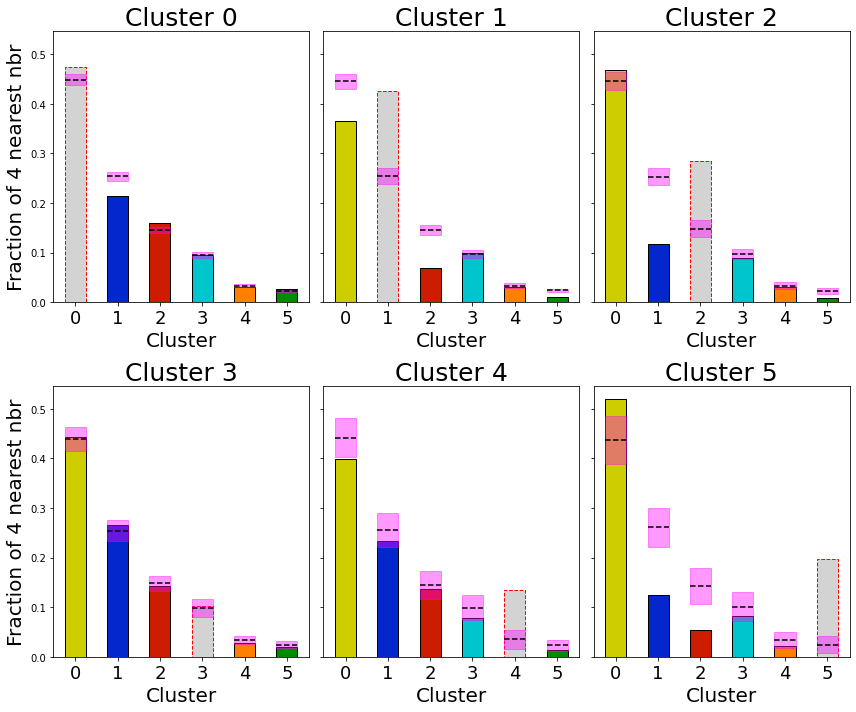

In [111]:
n_labels = len(all_sample_stats)
uni_labels = list(all_sample_stats.keys())
uni_labels.sort()

n_rows = 2
n_cols = int(np.ceil(n_labels / n_rows))

width = 0.5

fig,ax = plt.subplots(n_rows,
                      n_cols,
                      figsize = (n_cols * 4,
                                 n_rows * 5),
                      facecolor = "white",
                      sharey = True,
                     )

ax = ax.flatten()
#cmap = plt.cm.rainbow

cmap = {0: "#CDCD00",
        1 : "#0327CD",
        2 : "#CD1C00",
        3 : "#01C5CD",
        4 : "#FF7F00",
        5 : "#008B00",
       }

for k,label in enumerate(uni_labels):
    val = all_sample_stats[label].sum(axis=0)
    
    val /= val.sum()
    
    xs = np.arange(n_labels)
    bar = ax[k].bar(xs,
                    val,
                    edgecolor = "black",
                    facecolor ="lightgray",
                   width = width,
                   )

    
    for n,(p,l) in enumerate(zip(bar.patches,uni_labels)):
        if l != label:
            if l in cmap.keys():
                p.set_facecolor(cmap[l])
            else:
                p.set_facecolor(plt.cm.rainbow(n / n_labels))
        else:
            p.set_edgecolor("red")
            p.set_linestyle("dashed")
            
            
    if include_reference:
        for j in range(xs.shape[0]):
            x_vals = (xs[j] - width / 2, xs[j] + width / 2)
            y_vals = np.array((perm_stats[k]["mean"][j],
                               perm_stats[k]["mean"][j]))

            ax[k].fill_between(x_vals,
                               y_vals - 2*perm_stats[k]["std"][j],
                               y_vals + 2*perm_stats[k]["std"][j],
                                color = "magenta",
                                zorder = 10,
                               alpha = 0.4,
                       )

            ax[k].plot(x_vals,
                       y_vals,
                       color = "black",
                       linestyle = "dashed",
                       zorder = 11,
                        )
    
    ax[k].set_xticks(xs)
    ax[k].set_xticklabels(["{}".format(x) for x in uni_labels],
                          rotation = 0,
                          fontsize = 18)
    ax[k].set_title("Cluster {}".format(label),fontsize = 25)
    ax[k].set_xlabel("Cluster",fontsize = 20)
    
    if k % n_cols == 0:
        ax[k].set_ylabel("Fraction of {} nearest nbr".format(K),
                        fontsize = 20,
                        )

fig.tight_layout()
fig.savefig(osp.join(RES_DIR,"clu-nbr-stats.png"),
            dpi = 300)
plt.show()